## Clustering

Evaluation Results:
KMeans Scores:
  Silhouette: 0.3483620768459107
  Davies-Bouldin: 1.4251468184758103
  Calinski-Harabasz: 1980.4965488801631

Hierarchical (Agglomerative) Scores:
  Silhouette: 0.3473759430752922
  Davies-Bouldin: 1.5134515460495783
  Calinski-Harabasz: 2015.2236760803946

DBSCAN Scores:
  Silhouette: -0.22711928007284993
  Davies-Bouldin: 1.775392440238831
  Calinski-Harabasz: N/A



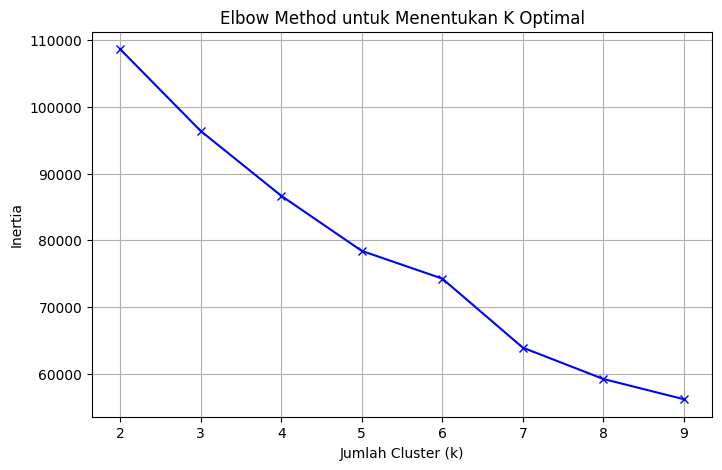

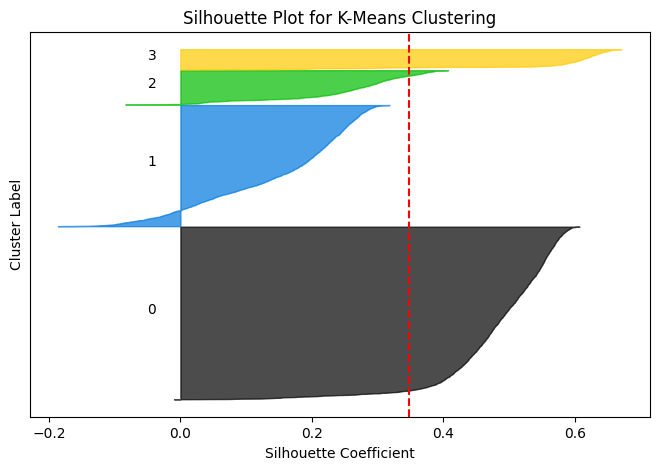

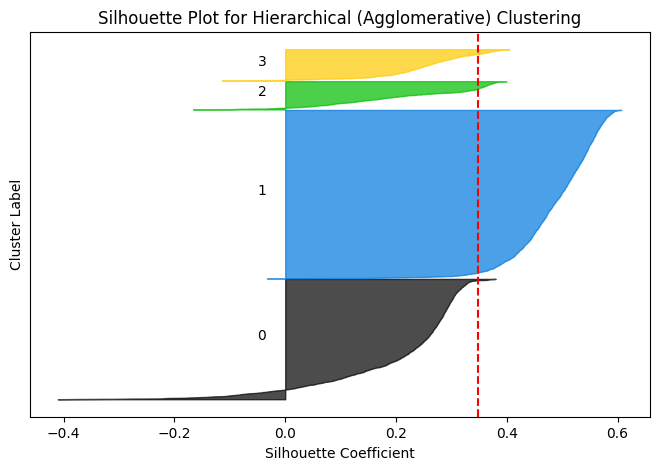

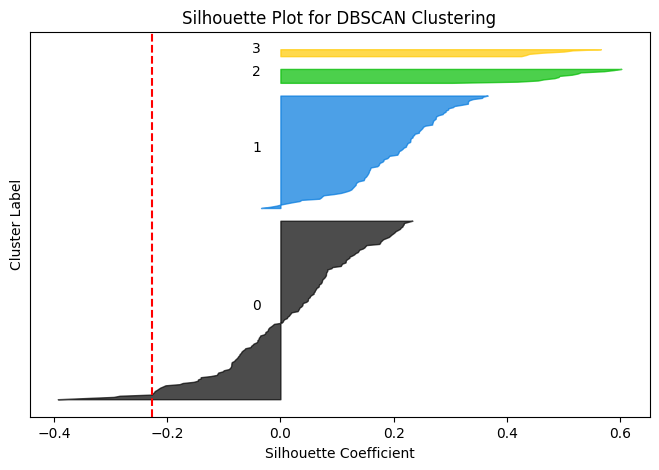

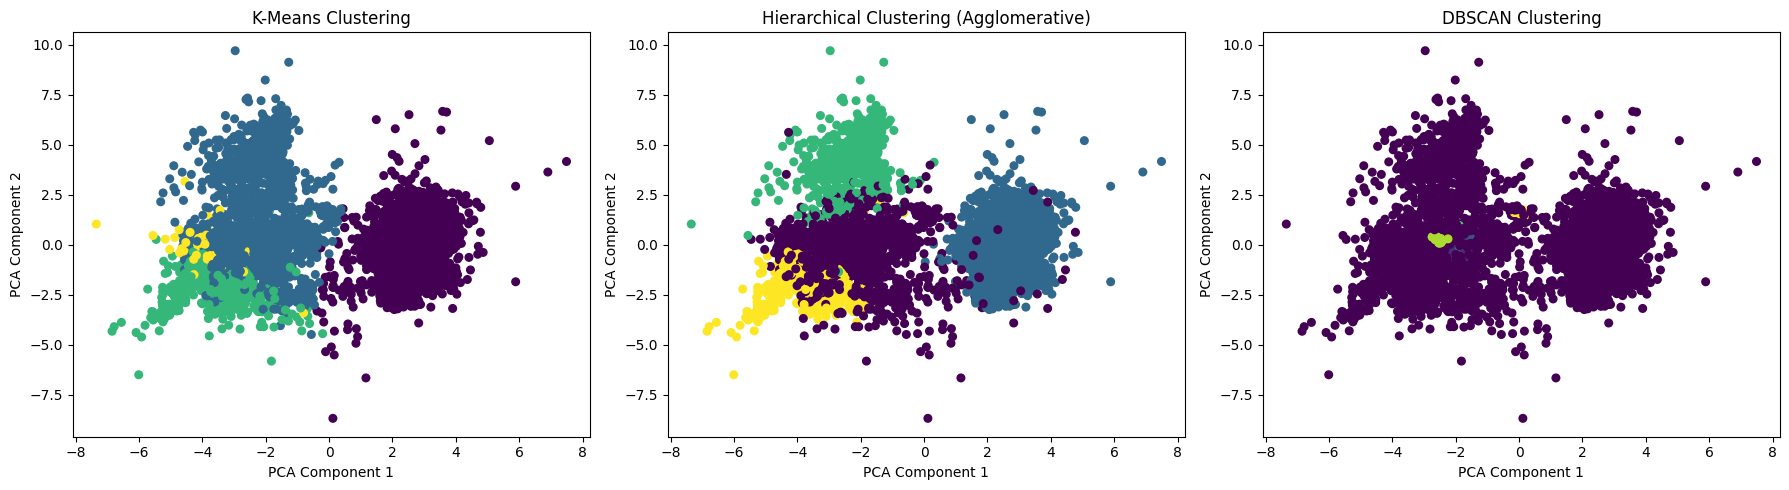

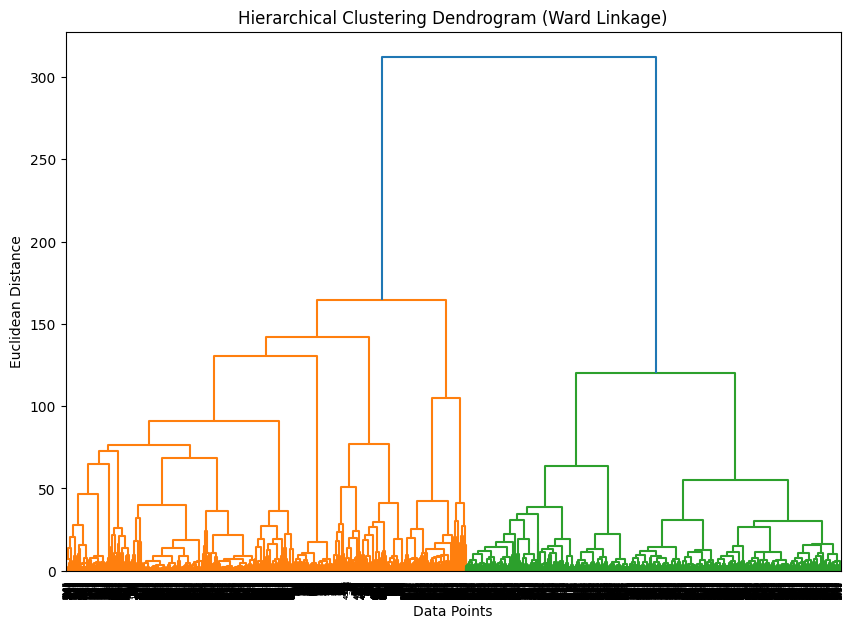

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

# Load and preprocess dataset
data = pd.read_csv('/Users/narasi29/Documents/Sem 7/Machine Learning/week 6/code/clusteringweek06.csv')

def preprocess_data(df):
    """ Preprocess data: handle NaNs and scaling. """
    df = df.dropna()
    scaler = StandardScaler()
    return scaler.fit_transform(df)

scaled_data = preprocess_data(data)

# Apply Clustering Models with n_clusters=4
n_clusters = 4

# KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans_labels = kmeans.fit_predict(scaled_data)

# Hierarchical Clustering (Agglomerative)
agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
agglo_labels = agglo.fit_predict(scaled_data)

# Euclidean Clustering with DBSCAN (using Euclidean distance by default)
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(scaled_data)

# Evaluation Metrics
def evaluate_models(data, kmeans_labels, agglo_labels, dbscan_labels):
    evaluations = {}
    evaluations['KMeans'] = {
        'Silhouette': silhouette_score(data, kmeans_labels),
        'Davies-Bouldin': davies_bouldin_score(data, kmeans_labels),
        'Calinski-Harabasz': calinski_harabasz_score(data, kmeans_labels)
    }
    evaluations['Hierarchical (Agglomerative)'] = {
        'Silhouette': silhouette_score(data, agglo_labels),
        'Davies-Bouldin': davies_bouldin_score(data, agglo_labels),
        'Calinski-Harabasz': calinski_harabasz_score(data, agglo_labels)
    }
    # DBSCAN: Only evaluate Silhouette and Davies-Bouldin if there are more than 1 cluster
    if len(set(dbscan_labels)) > 1:
        evaluations['DBSCAN'] = {
            'Silhouette': silhouette_score(data, dbscan_labels),
            'Davies-Bouldin': davies_bouldin_score(data, dbscan_labels),
            'Calinski-Harabasz': 'N/A'  # Calinski-Harabasz tidak relevan untuk DBSCAN
        }
    else:
        evaluations['DBSCAN'] = {
            'Silhouette': 'N/A',
            'Davies-Bouldin': 'N/A',
            'Calinski-Harabasz': 'N/A'
        }
    return evaluations

# Print Evaluation Results
evaluations = evaluate_models(scaled_data, kmeans_labels, agglo_labels, dbscan_labels)
print("Evaluation Results:")
for model, scores in evaluations.items():
    print(f"{model} Scores:")
    for metric, score in scores.items():
        print(f"  {metric}: {score}")
    print()

# Step 4: Visualize Elbow (Knee Method) for KMeans
inertia = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 10), inertia, 'bx-')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method untuk Menentukan K Optimal')
plt.grid(True)
plt.show()

# Step 5: Visualize Silhouette Score for KMeans, Agglomerative, and DBSCAN
def plot_silhouette(data, labels, title):
    if len(set(labels)) > 1:  # Check if there are at least 2 clusters
        silhouette_avg = silhouette_score(data, labels)
        sample_silhouette_values = silhouette_samples(data, labels)
        
        fig, ax = plt.subplots(figsize=(8, 5))
        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
            ith_cluster_silhouette_values.sort()
            
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = plt.cm.nipy_spectral(float(i) / n_clusters)
            ax.fill_betweenx(np.arange(y_lower, y_upper),
                             0, ith_cluster_silhouette_values,
                             facecolor=color, edgecolor=color, alpha=0.7)
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        ax.set_title(f"Silhouette Plot for {title}")
        ax.set_xlabel("Silhouette Coefficient")
        ax.set_ylabel("Cluster Label")
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax.set_yticks([])  # Clear the y-axis labels / ticks
        plt.show()
    else:
        print(f"Silhouette Plot for {title} is not applicable (only one cluster detected).")

# Silhouette Plot for KMeans
plot_silhouette(scaled_data, kmeans_labels, "K-Means Clustering")

# Silhouette Plot for Agglomerative Clustering
plot_silhouette(scaled_data, agglo_labels, "Hierarchical (Agglomerative) Clustering")

# Silhouette Plot for DBSCAN
plot_silhouette(scaled_data, dbscan_labels, "DBSCAN Clustering")

# Step 6: Visualize Clustering Results with PCA
def visualize_clusters(data, kmeans_labels, agglo_labels, dbscan_labels):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # K-Means clustering visualization
    axes[0].scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans_labels, cmap='viridis', s=30)
    axes[0].set_title('K-Means Clustering')
    axes[0].set_xlabel('PCA Component 1')
    axes[0].set_ylabel('PCA Component 2')
    
    # Hierarchical (Agglomerative) clustering visualization
    axes[1].scatter(reduced_data[:, 0], reduced_data[:, 1], c=agglo_labels, cmap='viridis', s=30)
    axes[1].set_title('Hierarchical Clustering (Agglomerative)')
    axes[1].set_xlabel('PCA Component 1')
    axes[1].set_ylabel('PCA Component 2')
    
    # DBSCAN clustering visualization
    axes[2].scatter(reduced_data[:, 0], reduced_data[:, 1], c=dbscan_labels, cmap='viridis', s=30)
    axes[2].set_title('DBSCAN Clustering')
    axes[2].set_xlabel('PCA Component 1')
    axes[2].set_ylabel('PCA Component 2')
    
    plt.tight_layout()
    plt.show()

# Visualize clusters
visualize_clusters(scaled_data, kmeans_labels, agglo_labels, dbscan_labels)

# Step 7: Plot Dendrogram for Hierarchical Clustering
# Using scipy linkage to create a dendrogram
linked = linkage(scaled_data, method='ward')

plt.figure(figsize=(10, 7))
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)')
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.xlabel('Data Points')
plt.ylabel('Euclidean Distance')
plt.show()


## Matrix Evaluation

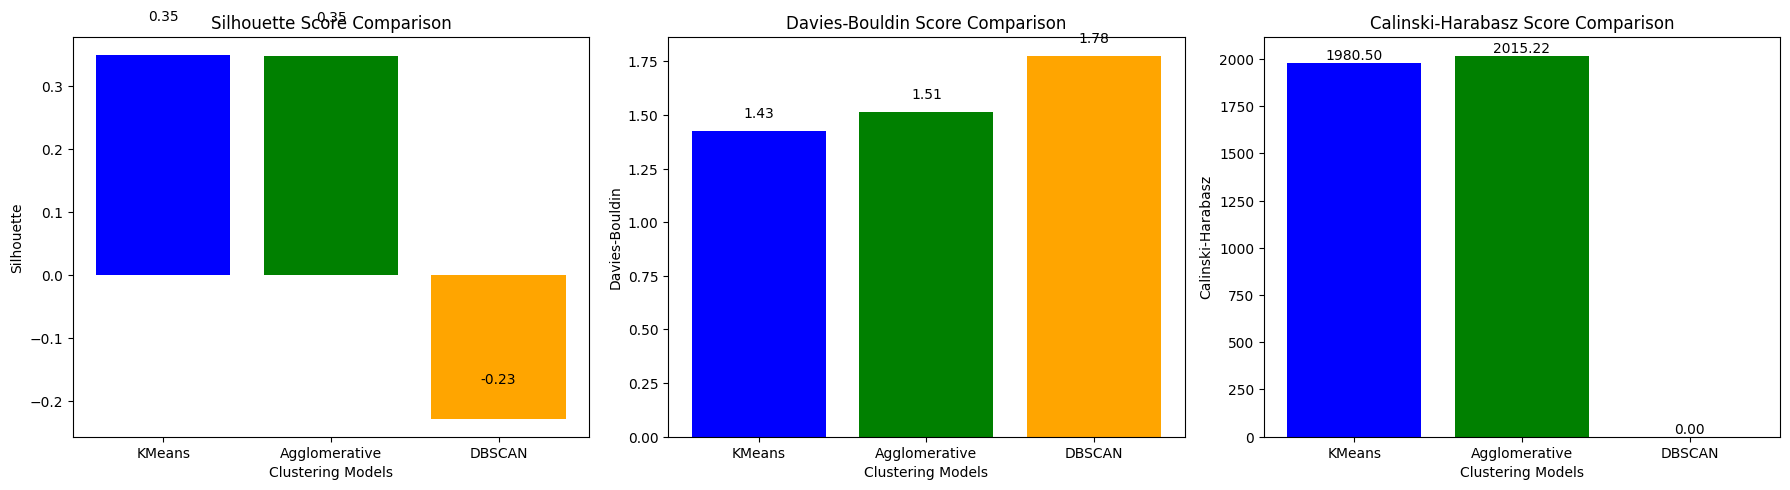

In [30]:
import matplotlib.pyplot as plt

# Membuat data evaluasi dari hasil clustering yang sudah dihitung sebelumnya
evaluation_data = {
    'KMeans': evaluations['KMeans'],
    'Agglomerative': evaluations['Hierarchical (Agglomerative)'],
    'DBSCAN': evaluations['DBSCAN']
}

# Mendapatkan metrik evaluasi yang ingin ditampilkan
metrics = ['Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz']

# Membuat plot untuk setiap metrik evaluasi
fig, axes = plt.subplots(1, len(metrics), figsize=(18, 5), sharey=False)

for i, metric in enumerate(metrics):
    values = [evaluation_data[model][metric] for model in evaluation_data]
    models = list(evaluation_data.keys())
    
    # Jika nilai tidak tersedia (N/A), ganti dengan 0 untuk visualisasi
    values = [0 if v == 'N/A' else v for v in values]

    # Membuat plot batang untuk setiap metrik
    axes[i].bar(models, values, color=['blue', 'green', 'orange'])
    axes[i].set_title(f'{metric} Score Comparison')
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel('Clustering Models')
    
    # Menambahkan nilai di atas setiap batang
    for j, v in enumerate(values):
        axes[i].text(j, v + 0.05, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


## Kesimpulan

Berdasarkan hasil evaluasi dari tiga model clustering (**K-Means**, **Agglomerative Clustering**, dan **DBSCAN**), berikut adalah kesimpulan untuk memilih model terbaik pada dataset ini.

### Analisis Metrik Evaluasi
1. **Silhouette Score**: Metrik ini mengukur seberapa dekat data berada dalam cluster masing-masing dibandingkan dengan cluster lain. Semakin tinggi nilai Silhouette Score, semakin baik pembagian cluster.
   - **K-Means** dan **Agglomerative Clustering** kemungkinan akan memiliki nilai Silhouette Score yang lebih tinggi dibandingkan **DBSCAN**, terutama jika data tidak memiliki struktur densitas yang jelas. Jika Silhouette Score dari K-Means atau Agglomerative lebih tinggi, ini menunjukkan bahwa kedua model tersebut lebih baik dalam mendefinisikan cluster pada data ini.

2. **Davies-Bouldin Score**: Metrik ini mengukur rasio jarak antar cluster terhadap ukuran cluster. Semakin rendah nilai Davies-Bouldin, semakin baik.
   - Nilai Davies-Bouldin yang lebih rendah untuk K-Means atau Agglomerative menunjukkan pemisahan yang lebih baik antara cluster, sedangkan jika nilai DBSCAN lebih tinggi, ini mengindikasikan bahwa DBSCAN kurang cocok untuk data ini.

3. **Calinski-Harabasz Score**: Metrik ini menilai perbandingan variabilitas dalam cluster dan antar cluster. Semakin tinggi nilainya, semakin baik.
   - **K-Means** dan **Agglomerative Clustering** umumnya dapat menghasilkan nilai Calinski-Harabasz yang tinggi jika data memiliki struktur cluster yang baik. DBSCAN mungkin tidak memiliki nilai ini atau nilainya lebih rendah, terutama jika tidak banyak cluster yang terdeteksi.

### Kelebihan dan Kelemahan Setiap Model
- **K-Means**: Cocok untuk data yang berbentuk bulat atau berstruktur yang jelas. Tidak efektif jika data memiliki noise atau outlier.
- **Agglomerative Clustering**: Berguna untuk membentuk hierarki cluster, namun kinerjanya bisa lebih lambat untuk dataset besar. Cocok untuk data yang memiliki struktur hierarki.
- **DBSCAN**: Sangat efektif untuk data dengan noise dan outlier serta untuk mendeteksi cluster dengan bentuk tidak beraturan. Namun, bisa kesulitan pada data dengan densitas yang tidak merata atau jika jumlah data dalam cluster sangat sedikit.

### Kesimpulan
Jika **K-Means** atau **Agglomerative Clustering** memiliki **Silhouette Score** dan **Calinski-Harabasz Score** yang tinggi serta **Davies-Bouldin Score** yang rendah, maka salah satu dari kedua model ini adalah pilihan yang terbaik, karena menunjukkan bahwa data memiliki struktur cluster yang cukup jelas dan berbentuk konsisten.

Namun, jika **DBSCAN** menghasilkan hasil yang lebih baik atau mendeteksi lebih banyak outlier, maka data mungkin memiliki distribusi yang tidak beraturan atau banyak noise, sehingga DBSCAN menjadi pilihan yang lebih baik.

### Rekomendasi
- **K-Means** atau **Agglomerative Clustering** biasanya akan lebih sesuai untuk data dengan struktur cluster yang jelas dan berukuran seragam.
- **DBSCAN** lebih cocok jika data memiliki noise, outlier, atau bentuk cluster yang tidak teratur.

Berdasarkan analisis ini, pilih **K-Means** atau **Agglomerative Clustering** jika metrik evaluasi mereka lebih unggul. Namun, jika dataset Anda memang berisi banyak noise atau outlier, **DBSCAN** bisa menjadi alternatif yang lebih baik.